In [1]:
import numpy as np
import pandas as pd
import tabula
from tabula.io import read_pdf
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('ggplot')

##### Install and get tabula working (Windows)
- pip install tabula-py
- if you don't have it already, install [java](https://www.java.com/en/download/manual.jsp)
- If there’s a ```FileNotFoundError``` when it calls ```read_pdf()```, and when you type java on command line it says ```'java' is not recognized as an internal or external command, operable program or batch file```, you should set ```PATH``` environment variable to point to the Java directory.
- Find the main Java folder like ```jre...``` or ```jdk....``` On Windows 10 it was under ```C:\Program Files\Java```
- On Windows 10: Control Panel -> System and Security -> System -> Advanced System Settings -> Environment Variables -> Select PATH –> Edit
- Add the ```bin``` folder like ```C:\Program Files\Java\jre1.8.0_144\bin```, hit OK a bunch of times.
- On command line, ```java``` should now print a list of options, and ```tabula.read_pdf()``` should run

In [2]:
df = read_pdf('BreakupByLaunchDate.pdf', pages='all')

In [3]:
def PDF_data_cleaning(dfs):
    '''
    df = read_pdf('BreakupByLaunchDate.pdf', pages='all')
    df: a list of 12 dfs
    '''

    cols_replace = ['SATELLITE NAME', 'US SATELLITE NUMBER',
       'LAUNCH DATE', 'BREAKUP DATE', 'DEBRIS CATALOGED', 'DEBRIS ON-ORBIT',
       'APOGEE (KM)', 'PERIGEE (KM)', 'INCLINATION (DEG)', 'ASSESSED CAUSE',
       'ADDITIONAL INFORMATION', 'INTERNATIONAL DESIGNATOR']

    # pre-processing the last df to remove footnote
    dfs[19] = dfs[19][:-4]

    headers = None

    for i in range(len(dfs)):

        #drop column name that are "unnamed"
        columns_drop = [c for c in dfs[i].columns if 'Unnamed' in c]

        if columns_drop and len(columns_drop) > 2: 
            # if columns_drop is *not* empty
            dfs[i] = dfs[i].drop(columns=columns_drop)
            if i == 0:
                headers = dfs[i].columns
            
        else: 
            # replace headers when needed
            row = pd.Series(dfs[i].columns.values, index=dfs[i].columns)
            dfs[i] = dfs[i].append(row, ignore_index=True)
            
            # here we cannot avoid some manual adjustment
            if i < 19:
                dfs[i].columns = headers
                
            else: #i==19:
                dfs[i].drop(columns=['Unnamed: 0'], inplace=True)
                dfs[i]['INTERNATIONAL DESIGNATOR'] = dfs[i].iloc[:,0].apply(lambda x: x[-9:])
                dfs[i].iloc[:,0] = dfs[i].iloc[:,0].apply(lambda x: x[:-10])
                dfs[i].columns = cols_replace
                dfs[i] = dfs[i][headers]
        
        # get indices of the NaNs rows
        idx = dfs[i].iloc[:,1:].index[dfs[i].iloc[:,1:].isnull().all(axis=1)]
#         nans = dfs[i].iloc[idx] no need
        
        # combine the row that contains only NaN with the following row
        for j in idx:
            i_pev, i_next = j, j+1
            dfs[i].iloc[i_next,0] = str(dfs[i].iloc[i_pev,0]) + " " + str(dfs[i].iloc[i_next,0])
        
        dfs[i] = dfs[i].drop(idx.values, axis=0)
        
    res = pd.concat(dfs, ignore_index=True)
  
    return res

def post_process(df):
    
    # can be improved later
    df.loc[82,'BREAKUP DATE'] = '28-Jan-84'
    df.loc[118,'BREAKUP DATE'] = '19-Sep-87'
    df.loc[124,'BREAKUP DATE'] = '17-Dec-12'
    df.loc[150,'BREAKUP DATE'] = '1-May-96'
    df.loc[10,'BREAKUP DATE'] = '1-Jun-66'
    df.loc[63,'BREAKUP DATE'] = '1-Feb-80'
    df.loc[66,'BREAKUP DATE'] = '1-Apr-80'
    df.loc[75,'BREAKUP DATE'] = '1-Apr-81'
    df.loc[77,'BREAKUP DATE'] = '1-Dec-86'
    df.loc[141,'BREAKUP DATE'] = '1-Jul-92'
    df.loc[163,'BREAKUP DATE'] = '1-Feb-02'
    df.loc[190,'BREAKUP DATE'] = '22-Apr-05'
    df.loc[199,'BREAKUP DATE'] = '1-Sep-06'
    df.loc[230,'BREAKUP DATE'] = '4-Aug-15'
    df.loc[231,'BREAKUP DATE'] = '21-Dec-11'
    df.loc[241,'BREAKUP DATE'] = '12-Feb-18'
    df.loc[242,'BREAKUP DATE'] = '4-Sep-10'
    
    df['year_LAUNCH'] = pd.to_datetime(df['LAUNCH DATE'], format='%d-%b-%y',infer_datetime_format=True).dt.year
    df['year_BREAKUP'] = pd.to_datetime(df['BREAKUP DATE'], format='%d-%b-%y').dt.year

    df['year_LAUNCH'] = df['year_LAUNCH'].apply(lambda x: x-100 if x > 2020 else x)
    df['year_BREAKUP'] = df['year_BREAKUP'].apply(lambda x: x-100 if x > 2020 else x)

    return df


In [4]:
res = PDF_data_cleaning(df)
res = post_process(res)
# res.tail()

#### clean data of "HISTORY OF SATELLITE BREAKUPS BY LAUNCH DATE" from pdf

In [5]:
# all the data of "HISTORY OF SATELLITE BREAKUPS BY LAUNCH DATE" from pdf
res['DEBRIS CATALOGED'] = pd.to_numeric(res['DEBRIS CATALOGED'])
res['DEBRIS ON-ORBIT'] = pd.to_numeric(res['DEBRIS ON-ORBIT'])
res.head(10)

,SATELLITE NAME,INTERNATIONAL DESIGNATOR,US SATELLITE NUMBER,LAUNCH DATE,BREAKUP DATE,DEBRIS CATALOGED,DEBRIS ON-ORBIT,APOGEE (KM),PERIGEE (KM),INCLINATION (DEG),ASSESSED CAUSE,ADDITIONAL INFORMATION,year_LAUNCH,year_BREAKUP
0,TRANSIT 4A R/B,1961-015C,118,29-Jun-61,29-Jun-61,296.0,172.0,995,880,66.8,PROPULSION,ABLESTAR STAGE,1961.0,1961.0
1,SPUTNIK 29,1962-057A,443,24-Oct-62,29-Oct-62,24.0,0.0,260,200,65.1,PROPULSION,MOLNIYA FINAL STAGE,1962.0,1962.0
2,ATLAS CENTAUR 2,1963-047A,694,27-Nov-63,27-Nov-63,19.0,8.0,1785,475,30.3,PROPULSION,CENTAUR STAGE,1963.0,1963.0
3,COSMOS 50,1964-070A,919,28-Oct-64,5-Nov-64,96.0,0.0,220,175,51.2,DELIBERATE,SELF-DESTRUCT,1964.0,1964.0
4,COSMOS 57,1965-012A,1093,22-Feb-65,22-Feb-65,167.0,0.0,425,165,64.8,DELIBERATE,SELF-DESTRUCT,1965.0,1965.0
5,COSMOS 61-63 R/B,1965-020D,1270,15-Mar-65,15-Mar-65,147.0,18.0,1825,260,56.1,UNKNOWN,COSMOS SECOND STAGE,1965.0,1965.0
6,OV2-1/LCS 2 R/B,1965-082DM,1822,15-Oct-65,15-Oct-65,473.0,32.0,790,710,32.2,PROPULSION,TITAN TRANSTAGE,1965.0,1965.0
7,COSMOS 95,1965-088A,1706,4-Nov-65,15-Jan-66,1.0,0.0,300,180,48.4,UNKNOWN,NaN,1965.0,1966.0
8,OV2-3/ et al. R/B,1965-108A,1863,21-Dec-65,21-Dec-65,108.0,101.0,33660,165,26.4,PROPULSION,TITAN TRANSTAGE,1965.0,1965.0
9,OPS 3031,1966-012C,2015,15-Feb-66,15-Feb-66,38.0,0.0,270,150,96.5,UNKNOWN,INFLATABLE SPHERE,1966.0,1966.0


In [6]:
gb_debri = res.groupby('year_BREAKUP')[['DEBRIS CATALOGED', 'DEBRIS ON-ORBIT']].sum()
# accumulative groupby data for plotting
gb_debri_cum = gb_debri.cumsum()
gb_debri_cum.head()

,DEBRIS CATALOGED,DEBRIS ON-ORBIT
year_BREAKUP,,
1961.0,296.0,172.0
1962.0,320.0,172.0
1963.0,339.0,180.0
1964.0,435.0,180.0
1965.0,1330.0,331.0


In [7]:
# prepare gp data
data = pd.read_csv("space-track.gp.1206.csv",low_memory=False)
gp = data[['OBJECT_NAME','OBJECT_ID','LAUNCH_DATE','DECAY_DATE','CREATION_DATE','EPOCH','OBJECT_TYPE','APOAPSIS','PERIAPSIS','COUNTRY_CODE','MEAN_MOTION', 'ECCENTRICITY','PERIOD']]
gp['LAUNCH_DATE'] = pd.to_datetime(gp['LAUNCH_DATE'], format='%Y-%m-%d')
gp["Year_launch"] = gp['LAUNCH_DATE'].dt.year
gp['DECAY_DATE'] = pd.to_datetime(gp['DECAY_DATE'], format='%Y-%m-%d')
gp["Year_decay"] = gp['DECAY_DATE'].dt.year
gp = gp.fillna({'Year_decay':2020})

In [8]:
# filter only OBJECT_TYPE = ROCKET BODY
df_rocket_payload = gp[ (gp['OBJECT_TYPE']=='ROCKET BODY') | (gp['OBJECT_TYPE']=='PAYLOAD') ]
df_rocket_payload.head()

,OBJECT_NAME,OBJECT_ID,LAUNCH_DATE,DECAY_DATE,CREATION_DATE,EPOCH,OBJECT_TYPE,APOAPSIS,PERIAPSIS,COUNTRY_CODE,MEAN_MOTION,ECCENTRICITY,PERIOD,Year_launch,Year_decay
1,SL-3 R/B,1979-099B,1979-11-27,2004-05-07,2004-05-19T21:12:33,2004-05-07T08:25:52.317408,ROCKET BODY,149.335,132.186,CIS,16.494613,0.001315,87.301,1979.0,2004.0
6,BLOCK DM-SL R/B,2000-066B,2000-10-21,2004-05-28,2004-05-25T14:10:45,2004-05-22T19:47:00.890304,ROCKET BODY,1464.316,106.633,SEAL,14.318755,0.094762,100.567,2000.0,2004.0
8,DELTA 2 R/B,2004-014B,2004-04-20,2004-05-27,2004-05-27T08:20:35,2004-05-27T12:49:57.548639,ROCKET BODY,141.058,132.643,US,16.509464,0.000646,87.222,2004.0,2004.0
9,SOYUZ-TM 31,2000-070A,2000-10-31,2001-05-06,2004-05-27T14:23:33,2001-05-04T20:46:05.247264,PAYLOAD,402.574,379.282,CIS,15.588714,0.001721,92.374,2000.0,2001.0
11,SL-3 R/B,1979-067B,1979-07-20,2001-05-11,2004-05-27T14:23:57,2001-05-10T15:27:08.487072,ROCKET BODY,147.293,135.867,CIS,16.491502,0.000876,87.317,1979.0,2001.0


In [9]:
gp_rs = df_rocket_payload.groupby(['OBJECT_TYPE','Year_launch','Year_decay'])['OBJECT_ID'].count()
rs_df = pd.DataFrame(gp_rs)
rs_df.columns = ['Count']
rs_df.reset_index(inplace=True)
# rs_df

In [10]:
years_obs = [1958, 1961, 1964, 1967, 1971, 1974, 1977, 1980, 1984, 1987, 1990,
       1993, 1997, 2000, 2003, 2006, 2007, 2009, 2010, 2013, 2016, 2018, 2019, 2020]

count_objs = pd.DataFrame(data={}, columns=df_rocket_payload['OBJECT_TYPE'].unique(), index = years_obs)

def count_obj(data):
    for name, gp in rs_df.groupby('OBJECT_TYPE'):
        for y in years_obs:
            # denote SD = Year_epoch, ED = Year_decay and DD = Year_debut
            count_objs.loc[y, name] = len(gp[ (gp['Year_launch'] <= y) & (gp['Year_decay'] >= y) ])

In [11]:
count_obj(rs_df)
count_objs.head()

,ROCKET BODY,PAYLOAD
1958,1,4
1961,13,19
1964,38,48
1967,71,82
1971,105,122


In [12]:
x1 = count_objs.index
y1 = count_objs['ROCKET BODY'].cumsum()
y2 = count_objs['PAYLOAD'].cumsum()
x3 = gb_debri_cum.index
y3 = gb_debri_cum['DEBRIS CATALOGED']
y4 = gb_debri_cum['DEBRIS ON-ORBIT']

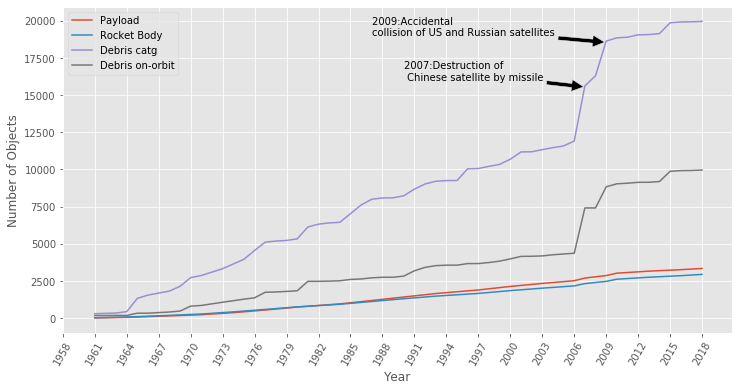

In [13]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(x1[1:-2].to_numpy(),y1[1:-2].to_numpy(), label='Payload')
ax.plot(x1[1:-2].to_numpy(),y2[1:-2].to_numpy(), label='Rocket Body')
ax.plot(x3.to_numpy(),y3.to_numpy(), label='Debris catg')
ax.plot(x3.to_numpy(),y4.to_numpy(), label='Debris on-orbit')
x_ticks = list(np.arange(1958, 2020, 3))
plt.xticks(x_ticks)
plt.xticks(rotation=60)
ax.annotate('2007:Destruction of\n Chinese satellite by missile', xy=(2007,15550), xytext=(1990, 16000),arrowprops=dict(facecolor='black', shrink=0.03))
ax.annotate('2009:Accidental \ncollision of US and Russian satellites', xy=(2009,18550), xytext=(1987, 19000),arrowprops=dict(facecolor='black', shrink=0.03))
ax.set_xlabel("Year")
ax.set_ylabel("Number of Objects")
plt.legend();